
- Design U-Net to segment the lung fields from chest computed tomography CT images (download from [here](https://drive.google.com/file/d/1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9/view?usp=sharing)) into one of the 2 classes lung or chest (background)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## `+` Import Libraries

In [ ]:
# !pip install tensorflow

In [55]:
import gdown
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing import image_dataset_from_directory
from glob import glob
import matplotlib.pyplot as plt

from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, Lambda
from keras.layers import Input, Dense, Activation, Conv2D, MaxPool2D, Flatten
from keras.models import Sequential, Model
from keras.layers import BatchNormalization

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input

# `+` Seed Value

In [3]:
SEED = 907

In [4]:
BATCH_SIZE = 8
EPOCHS = 50

## `+` Downlaod, Load & Preprocess Chest CT Data

### Download & Extract the Dataset

In [10]:
file_id = "1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9"
gdown.download(f"https://drive.google.com/uc?id={file_id}",output="Lung_Data.zip", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9
From (redirected): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9&confirm=t&uuid=41f73c0c-e09e-4b13-aa42-8bae9f5ebe97
To: /content/Lung_Data.zip
100%|██████████| 41.1M/41.1M [00:00<00:00, 115MB/s]


'Lung_Data.zip'

In [11]:
%%capture
!unzip Lung_Data.zip

### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [12]:
folders = ['grey', 'mask']
for folder in folders:
    out_dir = f'Lung_Data_PNG/{folder}'
    os.makedirs(out_dir, exist_ok=True)
    for img in glob(f'Lung_Data/{folder}/*.bmp'):
        Image.open(img).save(os.path.join(out_dir, img.split('/')[-1].rsplit('.', maxsplit=1)[0] + '.png'), 'PNG')

In [13]:
gray_train_ds,gray_val_ds=image_dataset_from_directory(
    directory="/content/Lung_Data_PNG/grey",
    image_size=(512, 512),
    seed=SEED,
    batch_size=BATCH_SIZE,
    labels=None,
    color_mode="grayscale",
    validation_split=0.15,
    subset='both')


Found 216 files.
Using 184 files for training.
Using 32 files for validation.


In [14]:
mask_train_ds,mask_val_ds=image_dataset_from_directory(
    directory="/content/Lung_Data_PNG/mask",
    image_size=(512, 512),
    seed=SEED,
    batch_size=BATCH_SIZE,
    labels=None,
    color_mode="grayscale",
    validation_split=0.15,
    subset='both'
)

Found 216 files.
Using 184 files for training.
Using 32 files for validation.


In [15]:
#Train dataset
train=tf.data.Dataset.zip(gray_train_ds,mask_train_ds.map(lambda x: Rescaling(1./255)(x)))

In [17]:
# Validation dataset
val=tf.data.Dataset.zip(gray_val_ds,mask_val_ds.map(lambda x: Rescaling(1./255)(x)))

### Preview the Images

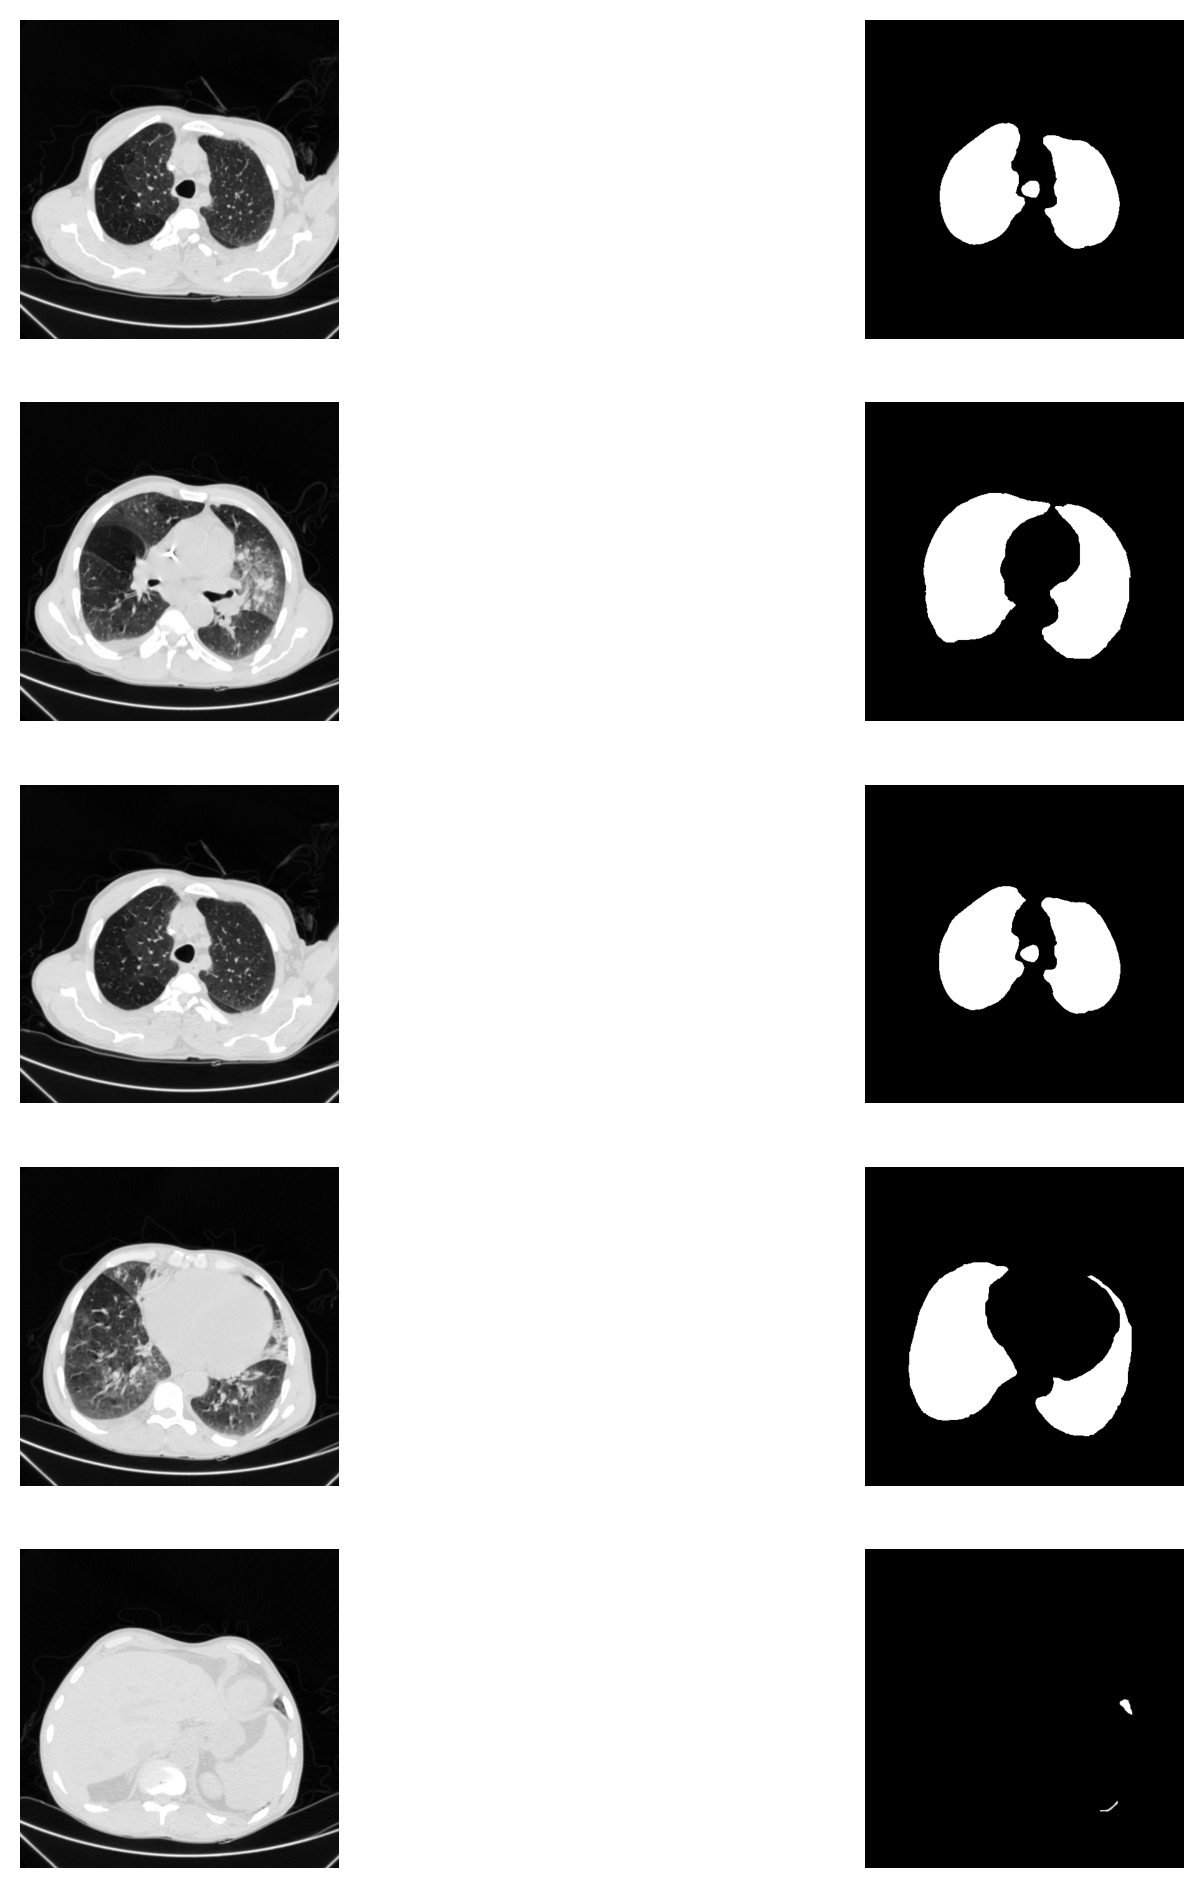

In [24]:
plt.figure(figsize=(10,12), dpi=200)
for images, masks in zip(gray_train_ds.take(4), mask_train_ds.take(4)):
    for i in range(5):
        plt.subplot(5, 2, i*2+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.subplot(5, 2, i*2+2)
        plt.imshow(masks[i], cmap='gray')
        plt.axis('off')

## `+` Set Global Parameters

In [38]:
# Hyperparameters
BATCH_SIZE = 8
EPOCHS = 50

## `i` Model Design

In [26]:
def double_conv(x, n_filters):
    x = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    return x

In [27]:
def downsample_block(x,n_filters):
  f=double_conv(x,n_filters)
  p=layers.MaxPool2D()(f)
  return f,p

In [28]:
def upsample_block(x,n_filters,conv_features):
  x=layers.Conv2DTranspose(n_filters,(3,3),strides=2,padding="same")(x)
  x=layers.concatenate([x,conv_features])
  x = double_conv(x,n_filters)
  return x

In [29]:
inputs = Input((512, 512, 1))
x=Rescaling(1./255)(inputs)
#Encoder
f1,p1=downsample_block(x,32)
f2,p2=downsample_block(p1,64)
f3,p3=downsample_block(p2,128)
f4,p4=downsample_block(p3,256)
#Bottleneck
Bottleneck=double_conv(p4,512)

#decoder
u6=upsample_block(Bottleneck,256,f4)
u7=upsample_block(u6,128,f3)
u8=upsample_block(u7,64,f2)
u9=upsample_block(u8,32,f1)

outputs=layers.Conv2D(1,(1,1),padding="same",activation="sigmoid")(u9)


## `ii` Model Compilation & Training

In [30]:
model = models.Model(inputs,outputs,name='LUNG_UNet')
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "LUNG_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        320 │ rescaling_3[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │  1,179,904 │ conv2d_9[0][0]  

 Total params: 8,629,921 (32.92 MB)

 Trainable params: 8,629,921 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)
]


In [39]:
history = model.fit(
    train,
    validation_data=val,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 604ms/step - accuracy: 0.9749 - loss: 0.0809 - val_accuracy: 0.9837 - val_loss: 0.0506 - learning_rate: 0.0010
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 610ms/step - accuracy: 0.9843 - loss: 0.0495 - val_accuracy: 0.9842 - val_loss: 0.0451 - learning_rate: 0.0010
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 604ms/step - accuracy: 0.9865 - loss: 0.0396 - val_accuracy: 0.9870 - val_loss: 0.0379 - learning_rate: 0.0010
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 595ms/step - accuracy: 0.9864 - loss: 0.0398 - val_accuracy: 0.9863 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 590ms/step - accuracy: 0.9868 - loss: 0.0387 - val_accuracy: 0.9886 - val_loss: 0.0324 - learning_rate: 0.0010
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 591ms/step - accuracy: 0.9894 - loss: 0.0307 - val_accuracy: 0.9894 - val_loss: 0.0303 - learning_rate: 0.0010
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 594ms/step - accuracy: 0.9889 - loss: 0.

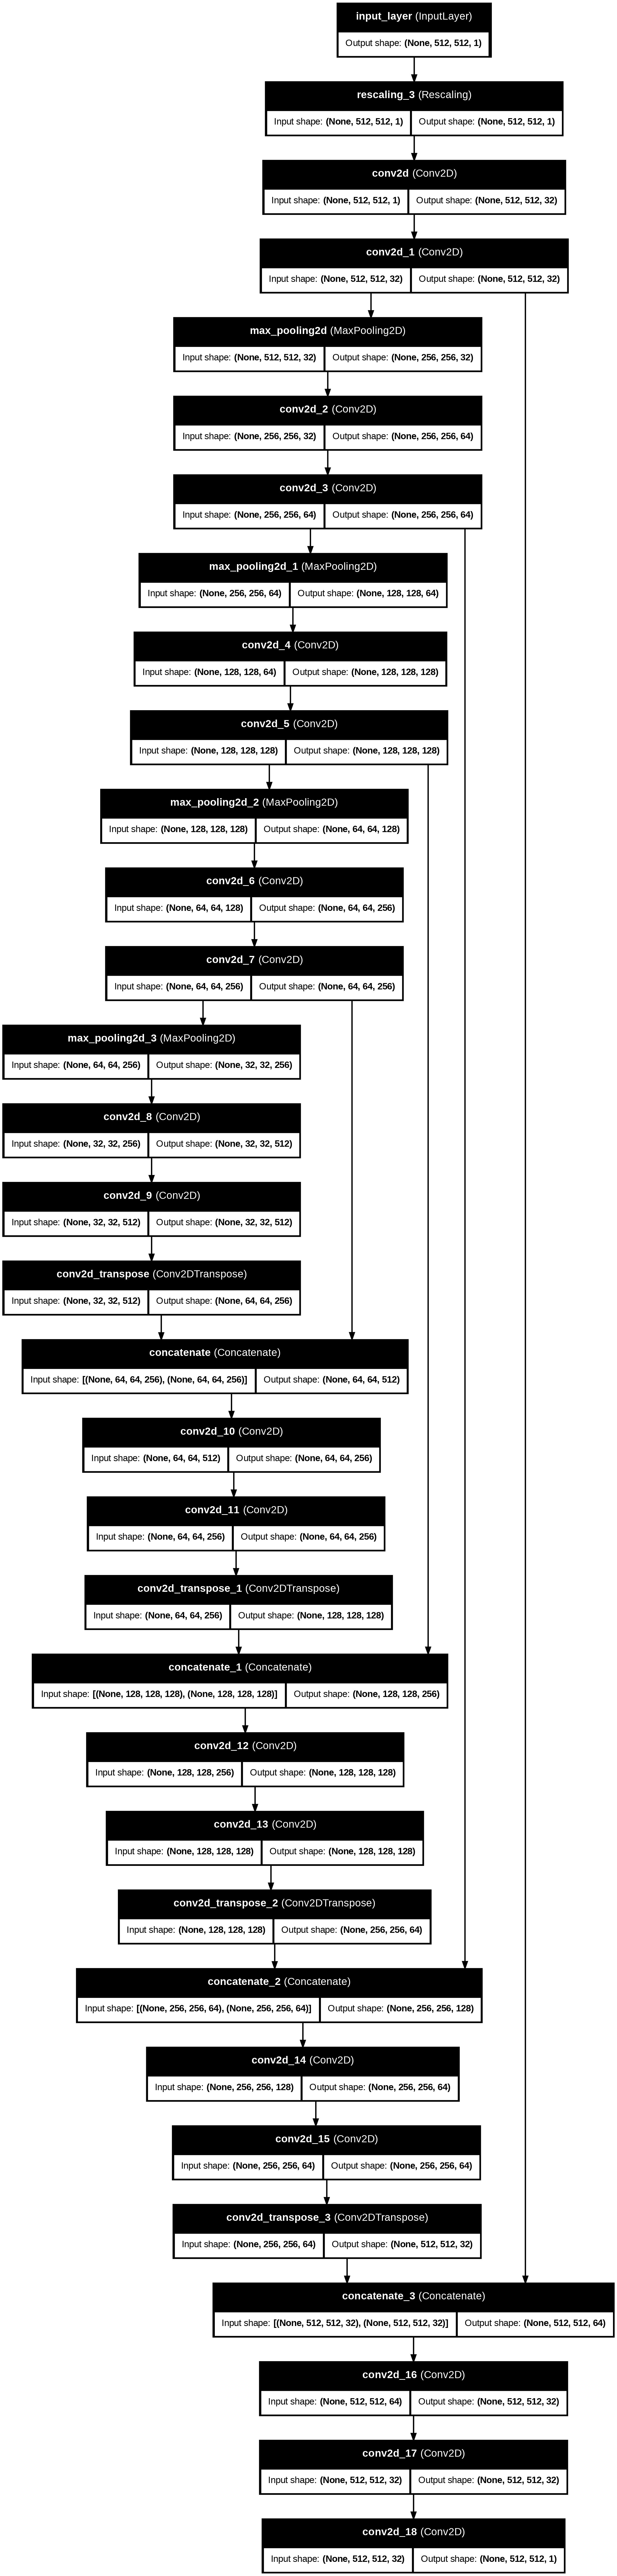

In [40]:
#the model architecture
plot_model(model, to_file='Lung_unet_model.png', show_shapes=True, show_layer_names=True)


## `iii` Model Evaluation

In [45]:
train_loss, train_acc = model.evaluate(train)
val_loss, val_acc = model.evaluate(val)

print(f"Accuracy for training: {train_acc * 100:.2f}")
print(f"Accuracy for validation: {val_acc * 100:.2f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 176ms/step - accuracy: 0.9929 - loss: 0.0204
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.9916 - loss: 0.0226
Accuracy for training: 99.26
Accuracy for validation: 99.22


## `iv` Result Visualization

---



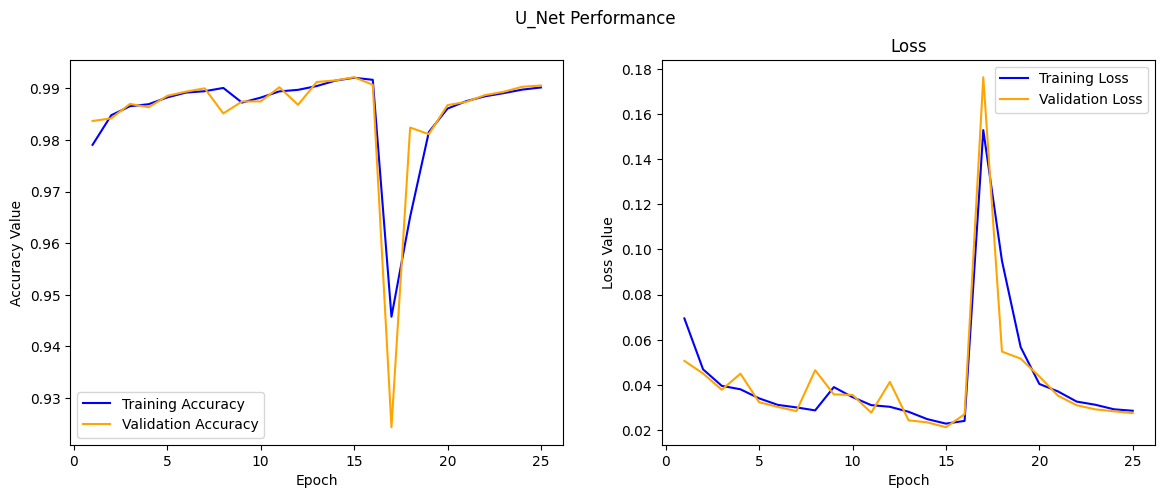

In [47]:
Acc = history.history['accuracy']
Val_Acc =history.history['val_accuracy']
Loss = history.history['loss']
Val_Loss = history.history['val_loss']
epochs = range(1, len(Acc) + 1)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

#Accuracy
ax[0].plot(epochs, Acc, label='Training Accuracy', color='blue')
ax[0].plot(epochs, Val_Acc, label='Validation Accuracy', color='orange')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy Value')
ax[0].legend()

fig.suptitle('U_Net Performance')
# Loss
ax[1].plot(epochs,Loss, label='Training Loss', color='blue')
ax[1].plot(epochs, Val_Loss, label='Validation Loss', color='orange')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss Value')
ax[1].legend()

plt.show();

## `v` It's Time for Segmentation!!

Let's try to predict the mask of some validation samples and plot the results.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


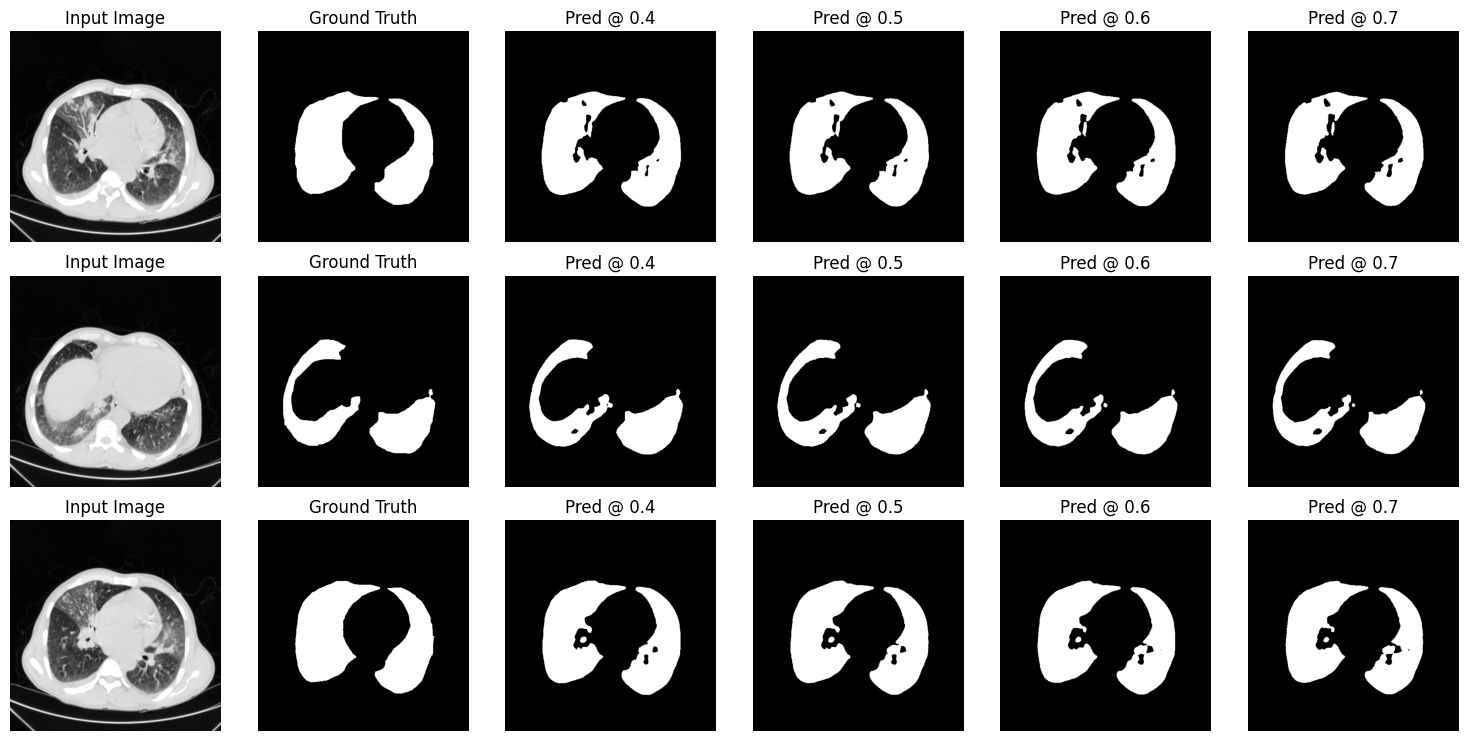

In [43]:
images, true_masks = next(iter(val.take(1)))

# Predict the masks
preds = model.predict(images)
thresholds = [0.4, 0.5, 0.6, 0.7]
num_samples = 3

plt.figure(figsize=(15, num_samples * 2.5))

for i in range(num_samples):
    # Show input image
    plt.subplot(num_samples, len(thresholds) + 2, i * (len(thresholds) + 2) + 1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray')
    plt.title("Input Image")
    plt.axis('off')

    # Show ground truth mask
    plt.subplot(num_samples, len(thresholds) + 2, i * (len(thresholds) + 2) + 2)
    plt.imshow(true_masks[i].numpy().squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    # Show predicted masks at different thresholds
    for j, thresh in enumerate(thresholds):
        plt.subplot(num_samples, len(thresholds) + 2, i * (len(thresholds) + 2) + 3 + j)
        plt.imshow((preds[i].squeeze() > thresh).astype(np.uint8), cmap='gray')
        plt.title(f"Pred @ {thresh}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# Design  Deep Convolutional Neural Network using `Transfer Learning`
## classify images of cats and dogs using the dataset [here](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip).

## `+` Downlaod, Load & Preprocess Cats & Dogs Data

### Download & Extract the Dataset

In [48]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  97.1M      0  0:00:08  0:00:08 --:--:-- 70.4M


In [49]:
!unzip -q kagglecatsanddogs_5340.zip
!ls -Rd PetImages/*

PetImages/Cat  PetImages/Dog


In [50]:
cat_path="/content/PetImages/Cat"
dog_path="/content/PetImages/Dog"

In [51]:
# Delete Corrupted Images
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [52]:
IMG_SIZE = 150
BATCH_SIZE = 32

In [59]:
#Train/Valdation
train_ds, val_ds = image_dataset_from_directory('PetImages',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                image_size=(180,180),
                                                validation_split=0.2,
                                                subset="both")

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


### Preview the Images

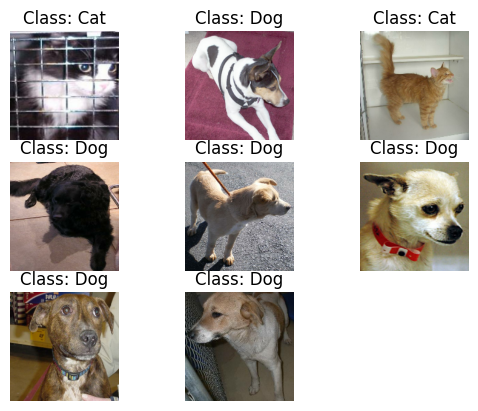

In [60]:
for images, labels in train_ds.take(1):
  for i in range(8):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.array(images[i]).astype('uint8'))
    plt.title(f'Class: {["Cat", "Dog"][labels[i]]}')
    plt.axis('off')

## `+` Set Global Parameters

## `i` Model Design

In [61]:
train_ds = train_ds.map(lambda image, label: (preprocess_input(image), label))
val_ds = val_ds.map(lambda image, label: (preprocess_input(image), label))

In [62]:
inputs = layers.Input(shape=(180, 180, 3))
x = RandomFlip()(inputs)
x = RandomRotation(0.2)(x)

In [63]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(180, 180, 3))
base_model.trainable = False
x =  base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## `ii` Model Compilation & Training

In [68]:
model = Model(inputs=base_model.input, outputs=predictions)

In [69]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 186, 186,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 90, 90,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 90, 90,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 90, 90,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 92, 92,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 45, 45,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 45, 45,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 45, 45,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 45, 45,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 45, 45,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 45, 45,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 45, 45,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 45, 45,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 45, 45,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 45, 45,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 45, 45,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [71]:
EPOCHS=15

In [72]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/15
586/586 ━━━━━━━━━━━━━━━━━━━━ 64s 109ms/step - accuracy: 0.9181 - loss: 0.1855 - val_accuracy: 0.9818 - val_loss: 0.0474
Epoch 2/15
586/586 ━━━━━━━━━━━━━━━━━━━━ 70s 88ms/step - accuracy: 0.9758 - loss: 0.0673 - val_accuracy: 0.9829 - val_loss: 0.0457
Epoch 3/15
586/586 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.9747 - loss: 0.0685 - val_accuracy: 0.9833 - val_loss: 0.0449
Epoch 4/15
586/586 ━━━━━━━━━━━━━━━━━━━━ 92s 107ms/step - accuracy: 0.9815 - loss: 0.0510 - val_accuracy: 0.9846 - val_loss: 0.0434
Epoch 5/15
586/586 ━━━━━━━━━━━━━━━━━━━━ 72s 90ms/step - accuracy: 0.9810 - loss: 0.0534 - val_accuracy: 0.9848 - val_loss: 0.0399
Epoch 6/15
586/586 ━━━━━━━━━━━━━━━━━━━━ 81s 89ms/step - accuracy: 0.9823 - loss: 0.0541 - val_accuracy: 0.9853 - val_loss: 0.0416
Epoch 7/15
586/586 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.9814 - loss: 0.0481 - val_accuracy: 0.9855 - val_loss: 0.0403
Epoch 8/15
586/586 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - accuracy: 0.9814 - loss: 0.0481 

## `iii` Model Evaluation

In [73]:
val_loss, val_accuracy = model.evaluate(val_ds)
train_loss, train_accuracy = model.evaluate(train_ds)

print(f"train  Accuracy: {train_accuracy}")
print(f'Validation Accuracy: {val_accuracy}')


147/147 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.9846 - loss: 0.0382
586/586 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - accuracy: 0.9957 - loss: 0.0177
train  Accuracy: 0.9959418773651123
Validation Accuracy: 0.9856898784637451


## `iv` Result Visualization

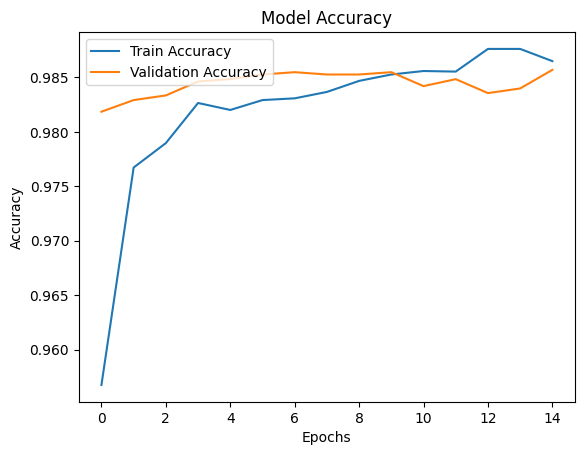

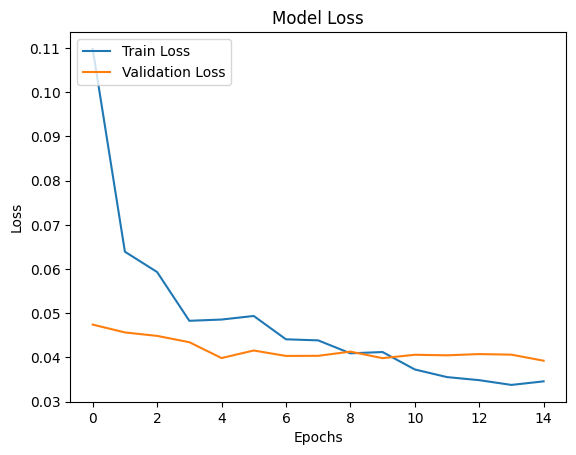

In [74]:
# Plot the training accuracy and loss

Acc = hist.history['accuracy']
Val_Acc =hist.history['val_accuracy']
Loss = hist.history['loss']
Val_Loss = hist.history['val_loss']
epochs = range(1, len(Acc) + 1)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
ax[0].plot(epochs, Acc, label='Training Accuracy', color='blue')
ax[0].plot(epochs, Val_Acc, label='Validation Accuracy', color='orange')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy Value')
ax[0].legend()

fig.suptitle('Pre_trained Performance')
# Plot Loss
ax[1].plot(epochs,Loss, label='Training Loss', color='blue')
ax[1].plot(epochs, Val_Loss, label='Validation Loss', color='orange')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss Value')
ax[1].legend()

plt.show();

##  Let's Test Our Model

In [77]:
test_image="/content/test.jpeg"

In [78]:
img = tf.keras.utils.load_img(test_image, target_size=(180, 180))
img_array = tf.keras.utils.img_to_array(img)
img_batch = tf.expand_dims(img_array, axis=0)
preprocessed_img = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])(img_batch)


In [79]:
prediction = model.predict(preprocessed_img)
class_label = "Cat" if prediction[0][0] >0.5 else "Dog"
print(f"Prediction: {class_label} (Confidence: {prediction[0][0]:.2f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Prediction: Dog (Confidence: 0.11)


In [81]:
# Plot the Input, True Label, and Predicted Label
def plot_prediction(model, image_path, true_label=None, image_size=(180, 180)):
    img = tf.keras.utils.load_img(image_path, target_size=image_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_batch = tf.expand_dims(img_array, axis=0)
    img_processed = tf.keras.layers.Rescaling(1./255)(img_batch)

    # Predict
    prediction = model.predict(img_processed)
    pred_class = 'Cat' if prediction[0][0] >0.5 else 'Dog'
    confidence = prediction[0][0] if pred_class == 'Cat' else 1 - prediction[0][0]

    # Plot image
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    title = f"Predicted: {pred_class} ({confidence:.2f})"
    if true_label:
        title = f"True: {true_label} | {title}"
    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


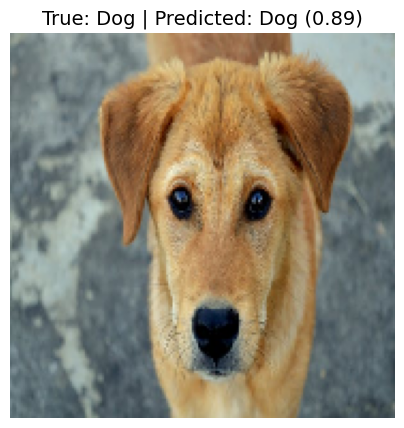

In [83]:
plot_prediction(model, "/content/test.jpeg", true_label='Dog')
